# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score, roc_auc_score, roc_curve, accuracy_score,
                             mean_squared_error, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector

In [4]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [5]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [6]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    """
    YOUR CODE IS HERE
    """
    
    return np.array(np.sin(2*w))

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [7]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [8]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w) #  YOUR CODE. Не забудьте про lr!

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [9]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

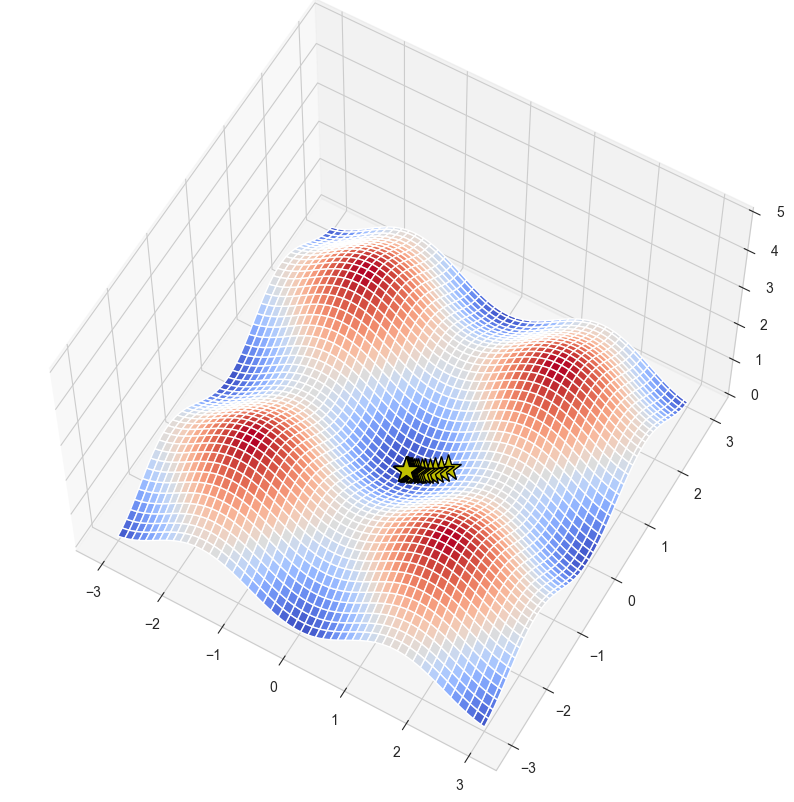

In [10]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

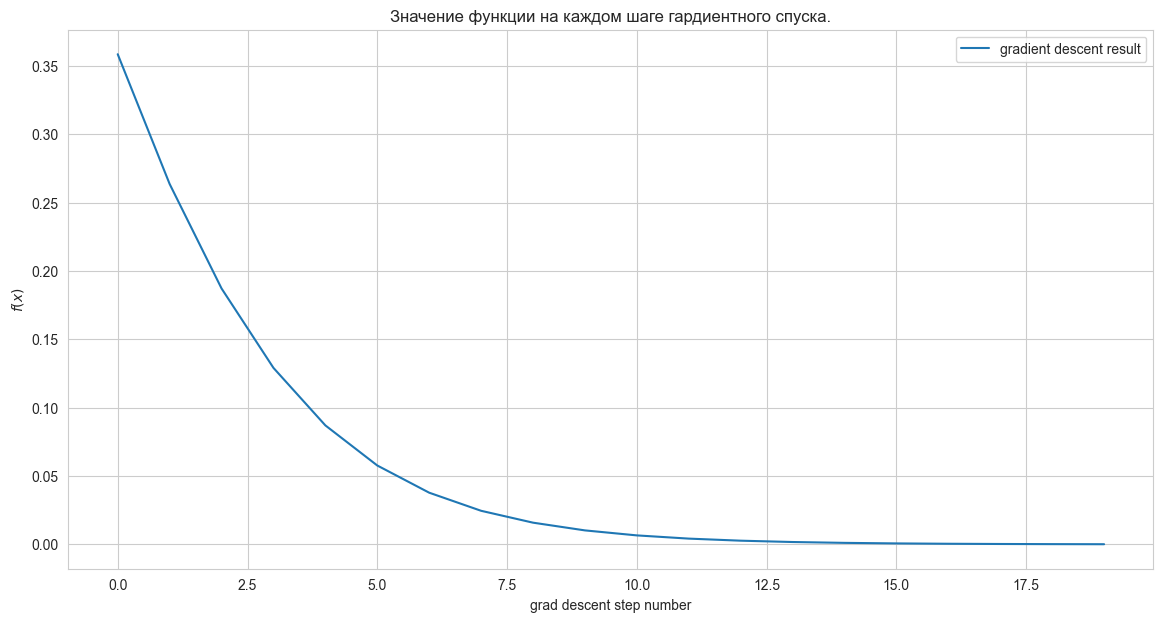

In [11]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [12]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """
    
    return np.mean((y_true - y_pred) ** 2)


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """
    
    return 2 * (X.T @ (y_pred - y_true)) / np.size(y_true)


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [13]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [14]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [15]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        """
        YOUR CODE IS HERE
        """
        return X_test @ self.W
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [16]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

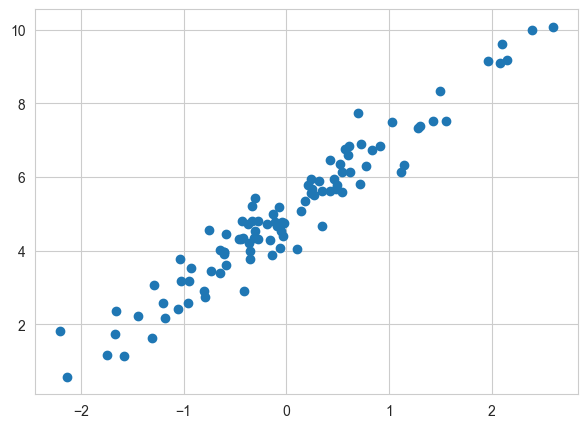

In [17]:
plt.figure(figsize=(7,5))
plt.scatter(X, y);

In [18]:
custom_lin_reg = CustomLinearRegression()

In [19]:
custom_lin_reg.fit(X, y)

My custom linear regression

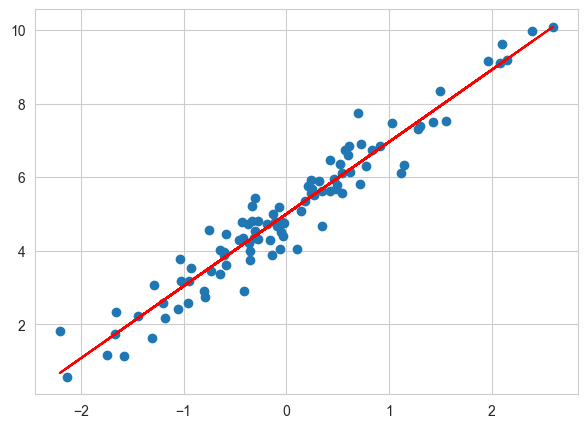

In [20]:
plt.figure(figsize=(7,5))
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X), c='red');

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [21]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

>Во славу Пандарии!

In [22]:
X = pd.DataFrame(data=X, columns=feature_names)
print(f'Всего имеется {len(X)} наблюдений')
X.head(3)

Всего имеется 20640 наблюдений


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


Все фичи численные, пропущенных значений нет:

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


**Хотим стандартизовывать?**

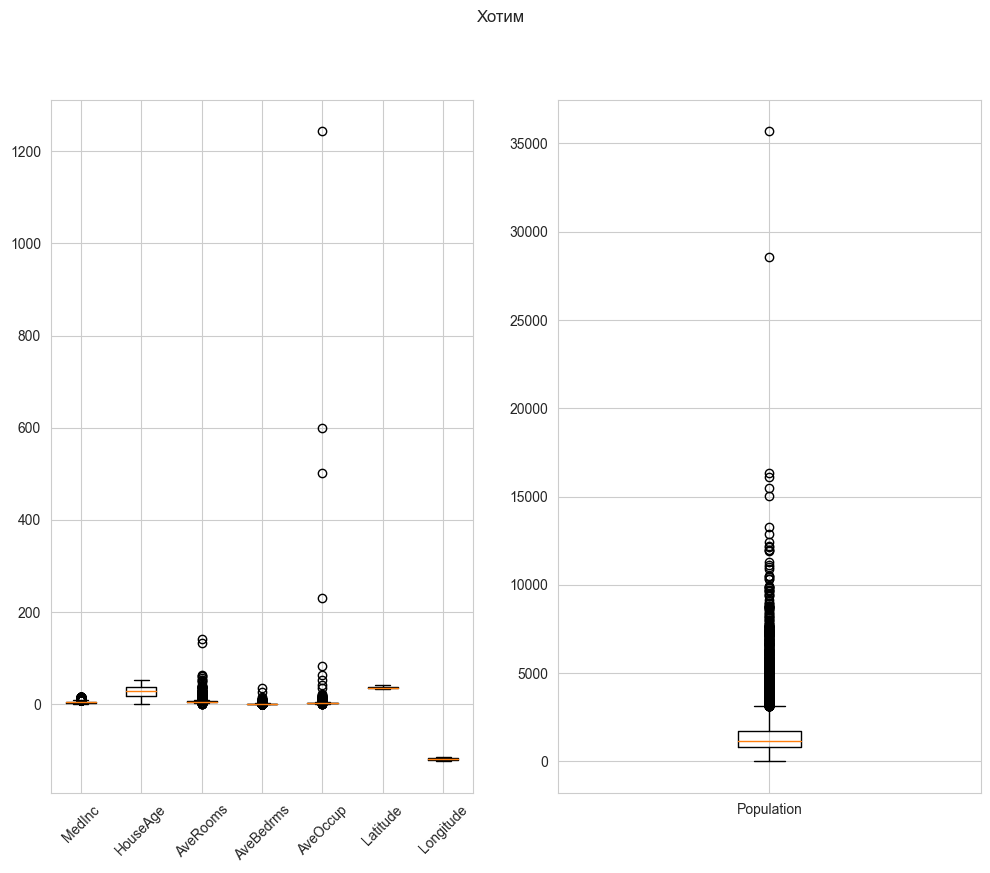

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Хотим')
ax1.boxplot(X.drop('Population', axis=1));
ax1.set_xticklabels(X.drop('Population', axis=1).columns,
                    rotation=45, fontsize=10);
ax2.boxplot(X.Population);
ax2.set_xticklabels(['Population'], fontsize=10);

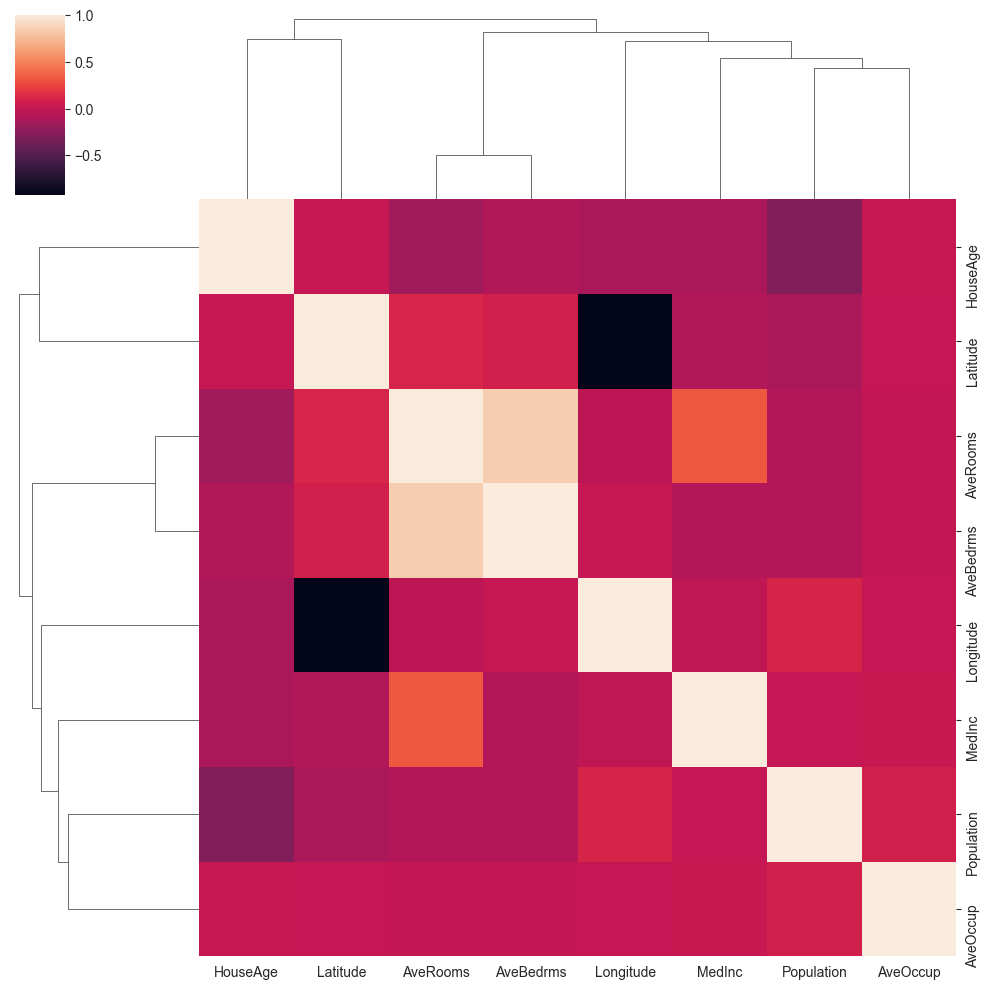

In [25]:
sns.clustermap(X.corr());

A еще мы видим что некоторые из этих фичей скореллированы (количества комнат и спален, а также долгота и широта). Количества комнат и спален очевидно ожидаются быть сильно скорелированными, так что одну из них мы уберем. А вот с долготой и широтой - это еще интереснее. Дело в том, что штат Калифорния (если я правильно понимаю откуда нам пришел датасет) - предельно вытянутый штат. При чем вытянут он слегка 'по-диагонали'. Это значит что чем больше широта, тем больше и долгота (если что вставил карту с подписями широт и долгот). 

> Как так? А почему в данных обратная корреляция??? (черные квадраты на графике выше)

Если достаточно помедитировать, можно понять что такого правда быть не может. Ответ прост - западная долгота идет 'налево' от нулевого мередиана и поэтому закодирована с минусом. Так что все ок. В общем суть в том, что можно смело выкинуть одно из наблюдений. Калифорния настолько сосисочная, что можно ее измерять не x-ом и у-ом, а лишь одной координатой (а в идеале вообще ).

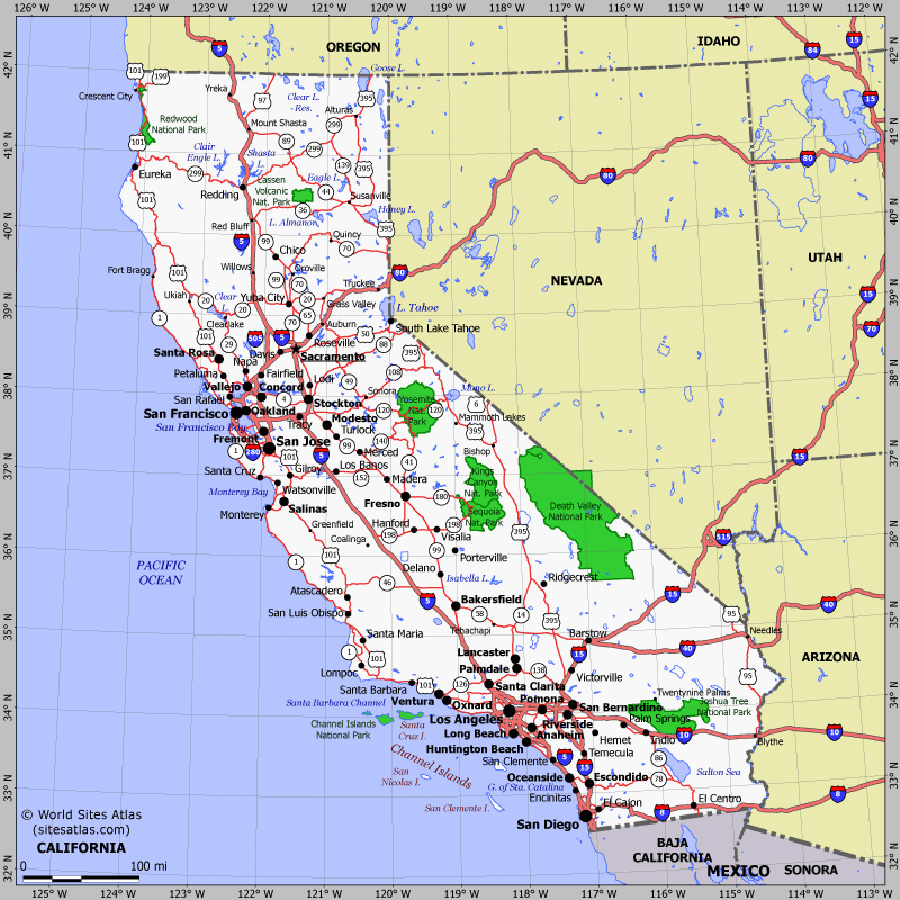

> **Погнали**

In [26]:
x = X.drop(['AveBedrms', 'Longitude'], axis =1)

In [27]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(),selector(dtype_include="float64"))])
lin_reg = LinearRegression()
lin_model = make_pipeline(preprocessor, lin_reg)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=SEED)
lin_model.fit(X_train, y_train)
y_predicted = lin_model.predict(X_test)

Некоторые метрики:

In [29]:
print('R^2 =',round(r2_score(y_test, y_predicted), 3))
print('MSE =',round(mean_squared_error(y_test, y_predicted), 3))

R^2 = 0.513
MSE = 0.655


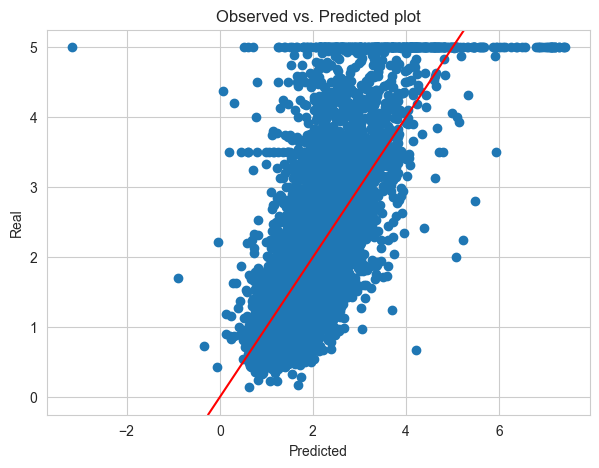

In [30]:
plt.figure(figsize=(7,5))
plt.scatter(x=y_predicted, y=y_test);
plt.axline([0, 0], [5, 5], c='red');
plt.title('Observed vs. Predicted plot');
plt.xlabel('Predicted');
plt.ylabel('Real');

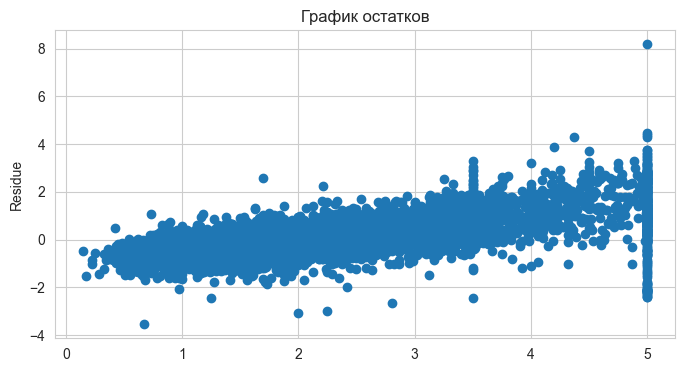

In [31]:
plt.figure(figsize=(8, 4))
plt.ylabel("Residue");
plt.title("График остатков");
plt.scatter(y_test, y_test-y_predicted);

> **Что можем сказать?**

В целом, модель неплохая. Имеющийся в данных тренд она улавливает, остатки распределены более-менее нормально для средних значений целевой переменной. 

Однако, видим что наша модель систематически недопредсказывает слишком высокие цены на жилье. Это видно и по графику observed vs. predicted, и по распределению остатков (остатки модели имеют тенденцию завышаться при увеличении целевой переменной). 

Также наблюдается, что в тестовой выборке целевой переменной отсутсвуют наблюдения свыше 5 у.е.. Модель же об этом ничего не знает и экстраполирует данные на большие значения целевой переменной  - это мы видим как характерные ужирненные 'обрубки' или 'культяпки' на обоих графиках. 

Какие признаки имеют большее влияние на модель?

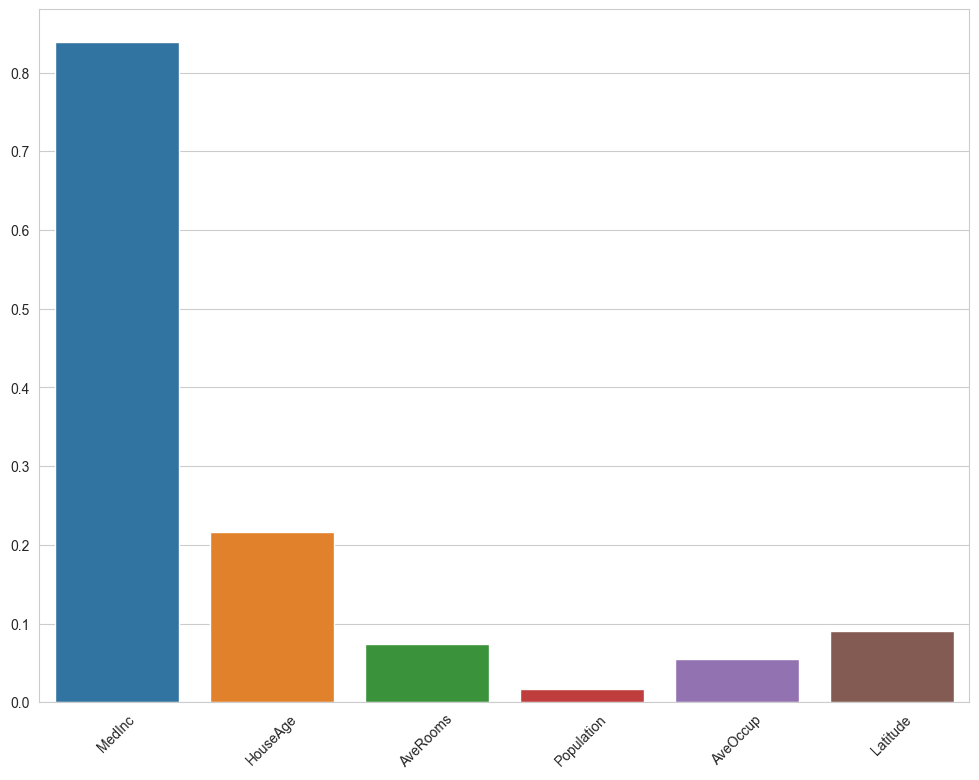

In [32]:
sns.barplot(x=x.columns, y=abs(lin_model[1].coef_))
plt.xticks(rotation=45);

Что интересно, если бы мы оставили все фичи, R^2 был бы чуть получше, но координаты имели бы огромный вес:

R^2 = 0.603
MSE = 0.534


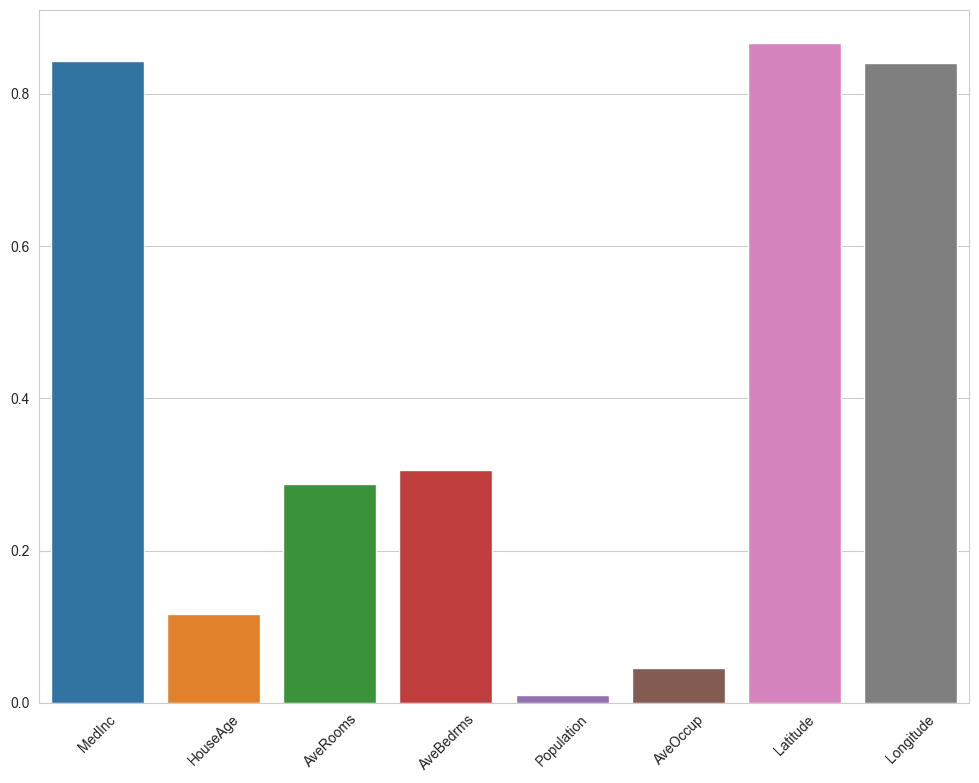

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)
lin_model.fit(X_train, y_train)
y_predicted = lin_model.predict(X_test)

print('R^2 =',round(r2_score(y_test, y_predicted), 3))
print('MSE =',round(mean_squared_error(y_test, y_predicted), 3))
sns.barplot(x=X.columns, y=abs(lin_model[1].coef_))
plt.xticks(rotation=45);

Для меня это выглядит так, что эти две переменные (долгота и широта) имеют большие коэффициенты (коеффициенты одного знака, если что, а вот переменные разного - долгота отрицательна) чтобы кое-как друг друга скомпенсировать. То есть на деле сами они не так важны. Может быть, стоит взять какую-то их комбинацию и она окажется полезной. Но не думаю. Калифорния - достаточно аграмрный край с двумя крупными городскими аггломерациями (задушнил). Так что скорее из долготы и широты зная координаты Лос-Анджелеса и Сан-Франциско, наверное, стоило бы вытащить, например, расстояние до города. 

Ну это так, размышления. 
В целом, как мы видим, наибольший вклад вносит медианный доход. 

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [34]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    """
    YOUR CODE IS HERE
    """
    return  1 / (1 + np.e**(- output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [35]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    """
    YOUR CODE IS HERE
    """
    return - np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / np.size(y_true)
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """
    return  X.T @ (y_pred - y_true)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [36]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        """
        YOUR CODE IS HERE
        """
        return sigmoid(X_test @ self.W)
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [37]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

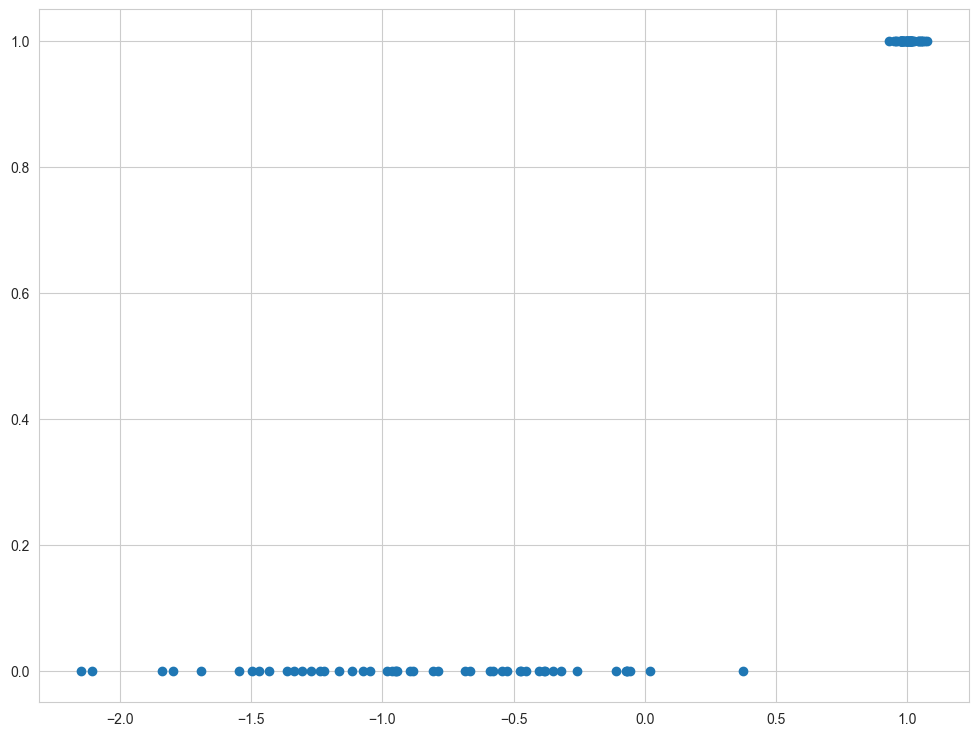

In [38]:
plt.scatter(X, y);

In [39]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

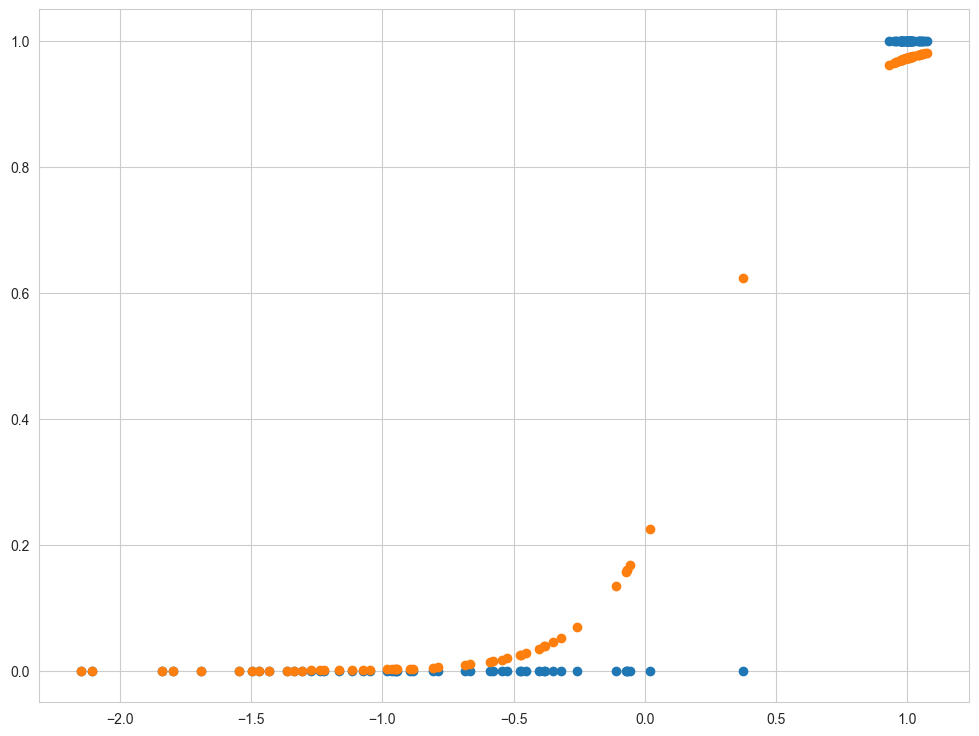

In [40]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [41]:
print('BCE: ', round(bce(y, y_pred), 3))
print('ROC-AUC', round(roc_auc_score(y, y_pred), 3))

BCE:  232.081
ROC-AUC 1.0


Видим, что наш классификатор будучи логистической регрессией вполне неплохо справляется с данной простой задачей.

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [42]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [43]:
pokemon[['Legendary']] = pokemon[['Legendary']].astype(int)

In [44]:
print(f'Всего имеется {len(pokemon)} наблюдений\n')
pokemon.info()

Всего имеется 800 наблюдений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    int32 
dtypes: int32(1), int64(9), object(3)
memory usage: 78.2+ KB


<AxesSubplot: >

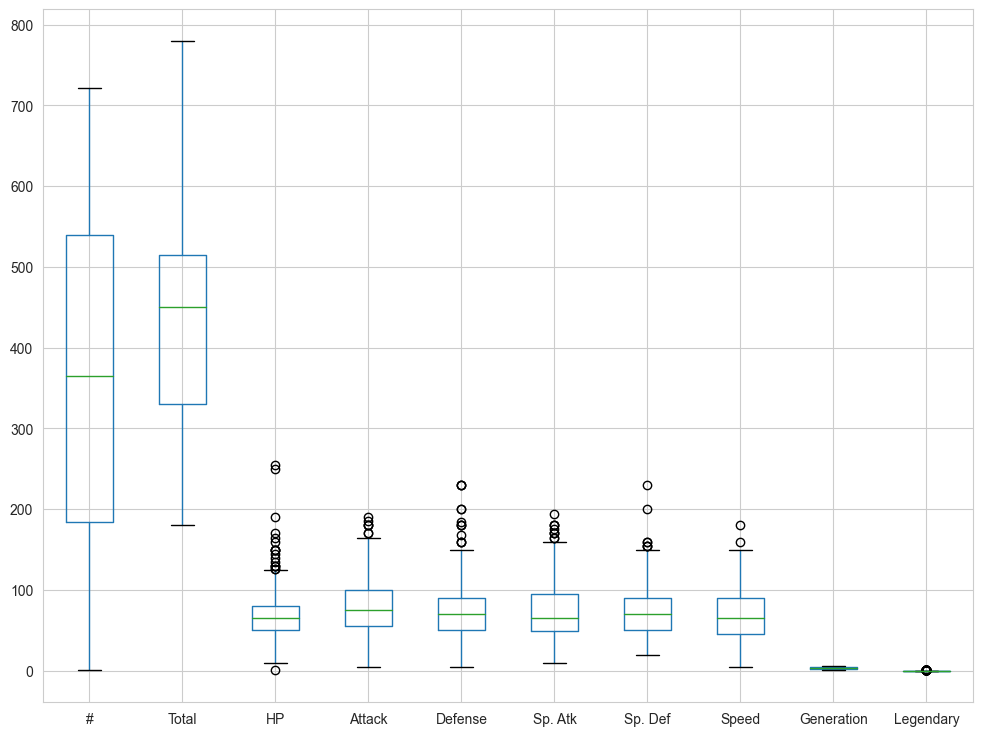

In [45]:
pokemon.boxplot()

Очевидно, надо будет стандартизовать.

> Пока разберемся с фичами. 

1.  Кажется подозрительным параметр решетка. Посмотрим что там.
2.  Имя? Конечно, интересно, но полезно для обучения будет? Посмотрим, если все имена уникальные, значит ни чем не полезнее банального raw index
3. Тип 1 и Тип 2 - что там? Почему в Тип 2 половина значений пропущены. Скорее всего это не банальные NaN.
4. Тотал - это тотал чего? Я погуглил - это сумма всех других фич. Значит выкидываем.
5. Поколение - это нумерикал или категорикал? Изучим.

In [46]:
pokemon[['Name']].value_counts().unique() # В топку имена

array([1], dtype=int64)

In [47]:
pokemon[['#']] # Веб-поиск дал понять что это ID. Не знаю почему здесь есть дупликаты, но в топку.

,#
0,1
1,2
2,3
3,3
4,4
...,...
795,719
796,719
797,720
798,720


In [48]:
print(pokemon['Type 1'].unique())
print(pokemon['Type 2'].unique()) # Доп. тип, не у всех есть.

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']
['Poison' nan 'Flying' 'Dragon' 'Ground' 'Fairy' 'Grass' 'Fighting'
 'Psychic' 'Steel' 'Ice' 'Rock' 'Dark' 'Water' 'Electric' 'Fire' 'Ghost'
 'Bug' 'Normal']


Не знаю, насколько эти типы влияют на легендарность. Основная проблема в том, что если влиянение есть то нам не важно какой тип в какой переменной - в 1 или в 2. Условно, если Электрик, то не важно по какому образованию. В общем чтобы не париться и похвастаться feature-generation сделаем просто маркер того, сколько типов у покемона:

In [49]:
pokemon['Double_typed'] = pokemon['Type 2'].notna().astype(int)

In [50]:
print(pokemon['Generation'].unique()) # На деле это категориальный признак. 

[1 2 3 4 5 6]


In [51]:
pokemon[['Legendary']].value_counts()  # А еще баланса классов не шибко есть :( Значит надо будет stratify y делать

Legendary
0            735
1             65
dtype: int64

Подготовим трансформатор наших данных!

In [52]:
num_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
cat_cols = ['Generation', 'Double_typed']
features = num_cols + cat_cols
X = pokemon[features]
y = pokemon['Legendary'].values

prepoccessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), cat_cols)
])

log_reg = LogisticRegression()
log_model = make_pipeline(prepoccessor, log_reg)

Разделите ваши данные на тестовую и тренировочную выборку.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, stratify=y)

Обучите модель `LogisticRegression` из `sklearn`.

In [54]:
log_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['HP', 'Attack', 'Defense',
                                                   'Sp. Atk', 'Sp. Def',
                                                   'Speed']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Generation',
                                                   'Double_typed'])])),
                ('logisticregression', LogisticRegression())])

In [56]:
y_pred = log_model.predict(X_test)
y_pred_prob = log_model.predict_proba(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

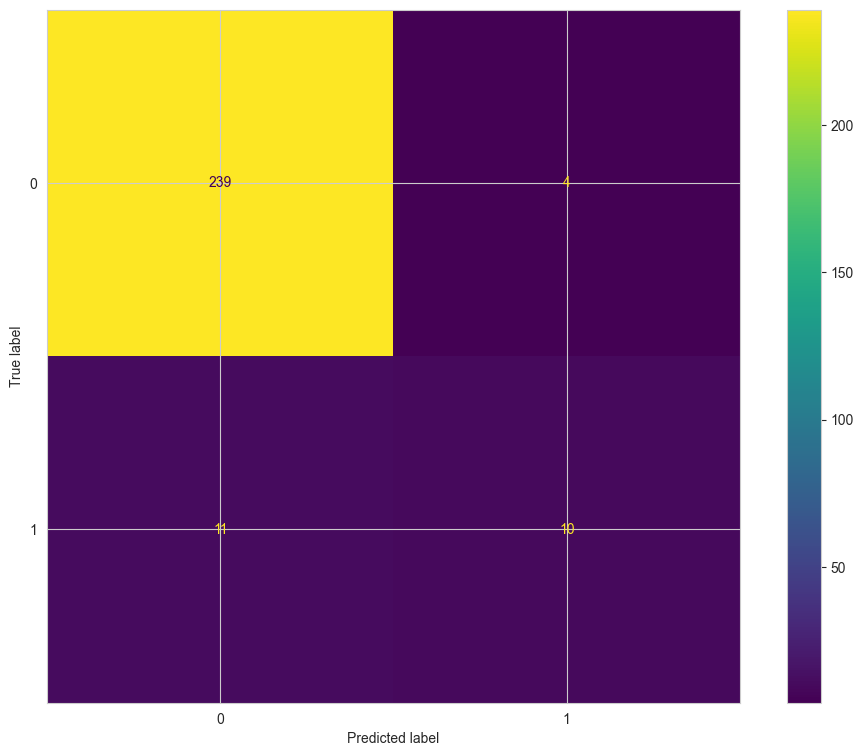

In [57]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot();

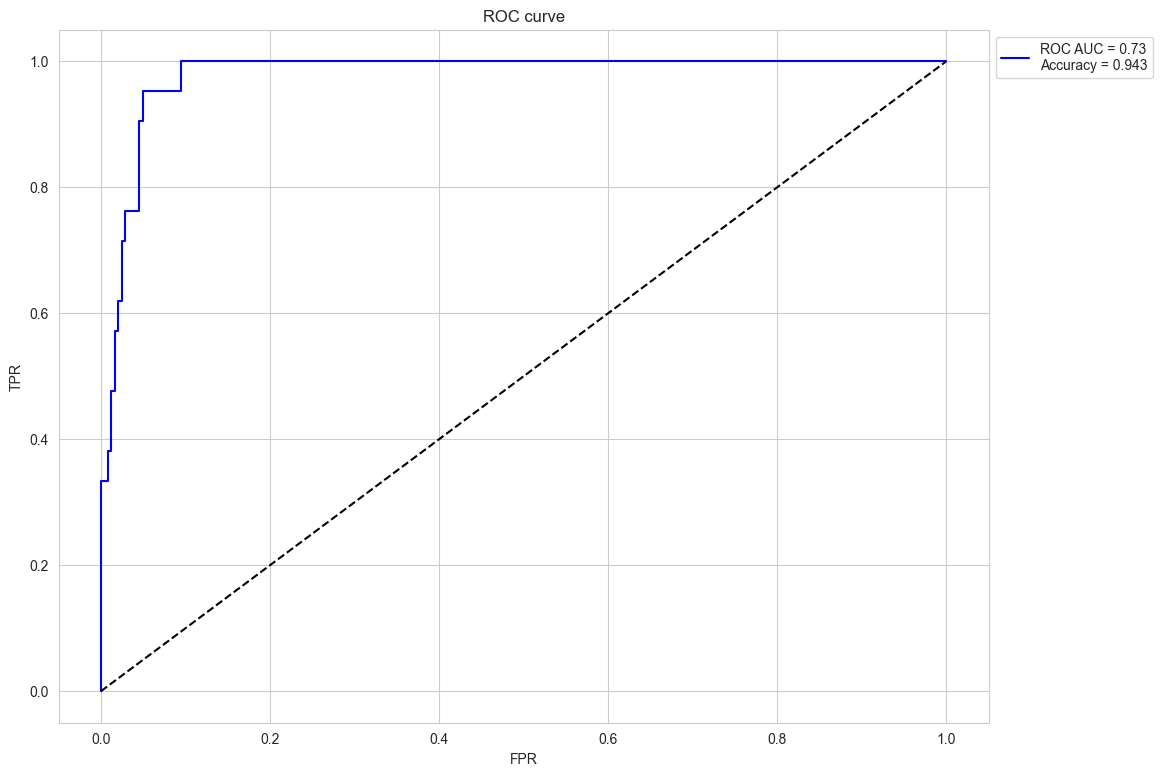

In [60]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc_text = f'ROC AUC = {round(roc_auc_score(y_test, y_pred), 3)}'
accuracy_text =  f'Accuracy = {round(accuracy_score(y_test, y_pred), 3)}'
legend =  roc_auc_text + '\n' + accuracy_text
plt.step(fpr, tpr, color='b', label = legend)
plt.plot(np.linspace(0,1,2), color = 'k', linestyle="--")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC curve')
plt.legend(bbox_to_anchor =(1,1))
plt.show()

Ну... что сказать. Так то метрики сносные даже. Но это модель просто вешает на всех лейбл 0. С учетом дисбаланса конечно было ожидаемо. 

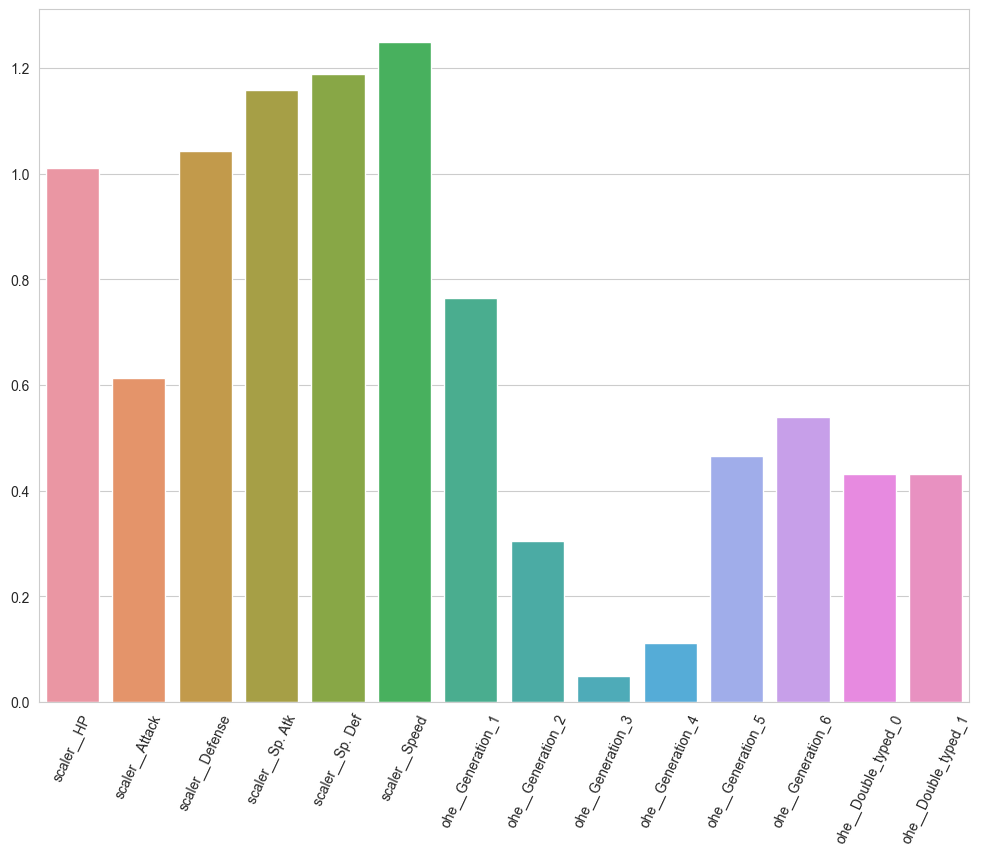

In [61]:
sns.barplot(x=list(log_model[:-1].get_feature_names_out()), y=abs(log_model[1].coef_[0]))
plt.xticks(rotation=65,);

Видим, что основную роль играет скорость, а также спец. навыки. На удивление, значение атаки не так сильно влияет, как здоровье или защита. Плюс, как мы можем судить, в поколении 1 больше Легендарных. 

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

> Однажды ВКонтакте я увидел пост с таким текстом: 'Если вы когда-либо о чем-то задумывались, то об этом есть песня у Anacondaz'. И там было несколько песен. Так я себе его и сохранил, и как это обычно бывает с сохраненными постами ...</br>
>Но года через два я к нему вернулся!</br>
> Что-то из старого:

<iframe frameborder="0" style="border:none;width:100%;height:180px;" width="100%" height="180" src="https://music.yandex.ru/iframe/#track/21287097/5913573">Слушайте <a href='https://music.yandex.ru/album/5913573/track/21287097'>CDMM</a> — <a href='https://music.yandex.ru/artist/762002'>Anacondaz</a> на Яндекс Музыке</iframe>

> Что-то из нового

<iframe frameborder="0" style="border:none;width:100%;height:180px;" width="100%" height="180" src="https://music.yandex.ru/iframe/#track/106102038/23076703">Слушайте <a href='https://music.yandex.ru/album/23076703/track/106102038'>Уходи</a> — <a href='https://music.yandex.ru/artist/762002'>Anacondaz</a> на Яндекс Музыке</iframe>

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Все было здорово🙃